In [1]:
from pya import *
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets
%matplotlib qt5
%matplotlib inline
import pandas as pd
import pyaudio
from collections import deque
import time

In [2]:
class SequenceStream2():
    def __init__(self, bs = 256,  sr = 44100, channels = 1, device_index = 1):
        self.pa = pyaudio.PyAudio()
        self.outputChannels =  channels # Work on this later. 
        self.fs = sr; self.chunk = bs # The smaller the smaller latency 
        self.audioformat = pyaudio.paInt16
        self.emptybuffer = np.zeros(self.chunk * self.outputChannels).astype(np.int16)
        self.output_idx = device_index
  
    def openstream(self):
        try:  
            self.playStream.stop_stream()
            self.playStream.close()
        except AttributeError:
            pass
        self.dataflag = False
        self.framecount = 0
        self.len = -1 
        self.playStream = self.pa.open(
            format = self.audioformat,
            channels = self.outputChannels, 
            rate = self.fs,
            input = False,
            output = True,
            output_device_index=self.output_idx,
            frames_per_buffer = self.chunk,
            stream_callback=self._playcallback
           )
        self.playStream.start_stream()

    def _unifySR(self, sig):
        srl = [s.sr for s in sig]

        if srl.count(srl[0]) == len(srl):
            return sig
        else:
            self.fs  = np.min(srl)
            for i in range(len(srl)): # resample asig that is > smallest sr. 
                if sig[i].sr != self.fs:
                    sig[i] = sig[i].resample(self.fs, 1)
            return sig
    
        
    def play(self, onset, siglist):
        
        # Before mixing, first convert to the lowest sampling rate. 
        sig = self._unifySR(siglist)

#         play_data = self.mixing_function(onset, sig)
#         play_data = (32767 * play_data).astype(np.int16)
#         self.play_data = self.makechunk(play_data, self.chunk)
#         self.framecount = 0
#         self.len = len(self.play_data)
# #         self.dataflag = True


    def mixing_function(self, onset, sig):
        maxlen = np.max([o + len(s) for o, s in zip(onset, sig)])
        result =  np.zeros(maxlen)
        for i in range(len(onset)):
            result[onset[i]:onset[i] + len(sig[i])] += sig[i] 
        return result

    def mix(self, onset, sig):
        siglengths = np.vectorize(len)(sig)
        maxlen = max(onset + siglengths)
        result = np.zeros(maxlen)
        for i in range(len(sig)):
            result[onset[i]: onset[i]+siglengths[i]] += sig[i]
        return result


    def makechunk(self, lst, chunk):
        result = []
        for i in np.arange(0, len(lst), chunk):
            temp = lst[i:i + chunk]
            if len(temp) < chunk:
                temp = np.pad(temp, (0, chunk - len(temp)), 'constant')
            result.append(temp)
        return result

    
    def _playcallback(self, in_data, frame_count, time_info, flag):  
        if (self.framecount < self.len):
            out_data = self.play_data[self.framecount]

            self.framecount +=1
        else:
            out_data = self.emptybuffer
        return bytes(out_data), pyaudio.paContinue

    def closestream(self):
        try: # To prevent self.playStream not created before stop button pressed
            self.playStream.stop_stream()
            self.playStream.close()
            print ("Play Stream Stopped. ")
        except AttributeError:
            print ("No stream, stop button did nothing. ")

In [3]:
# Try snap with lots of triggers. 
astereo = Asig("samples/stereoTest.wav", label='stereo')
# astereo.sig.shape[1]
# asen.size()
# onset = [0, 3000,10000]
# sig = [asen.sig, asen.sig, asen.sig]
# stream = SequenceStream2(bs = 512, sr = 24000)
# stream.openstream()


In [5]:

astereo.play(pan = [.8, .8 ])

Play sound. 


Asig('stereo'): 2 x 176400 @ 44100 Hz = 4.000 s

In [73]:
asen = Asig("samples/sentence.wav", label='sentence')
asen.channels

1

In [7]:
asen.play()

resample as sr is exotic
Play sound. 


Asig('sentence'): 1 x 61632 @ 24000 Hz = 2.568 s

In [10]:
asen.stop()

Play Stream Stopped. 


In [5]:
# sig1 = 0.3 * np.sin(2*np.pi * 300 * np.linspace(0,1,24000 * 2))
# sig2 = 0.3 * np.sin(2*np.pi * 6000 * np.linspace(0,1,24000 * 2))
# sig3 = 0.3 * np.random.random(24000 * 3) - 0.15
onset = [0, 24000, 48000]
# sig = [asen.sig, asen.sig, astereo.sig]

sig = [asen, asen, astereo]

In [41]:
stream = SequenceStream2(bs = 512, sr = 24000)
stream.openstream()
stream.play(onset, sig)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [6]:
astereo.overwrite(astereo.sig[:, 0])
print (astereo.channels)

1


Asig('stereo'): 2 x 176400 @ 44100 Hz = 4.000 s

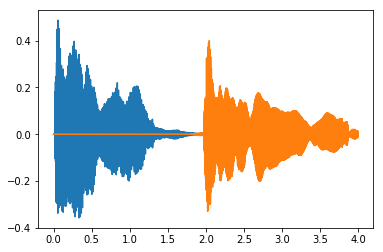

In [11]:
astereo.plot()

In [12]:
astereo.resample(24000)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [50]:
astereo.channels

2

In [ ]:
stream.closestream()

In [ ]:
plt.plot(sig1, 'r');plt.plot(sig2, 'b');plt.plot(sig3, 'g')

In [ ]:

# onset = np.array([0, 2000, 40000])
# sig = np.array([sig2, sig1, sig3])
# signal1 = np.array([1,2,3,4])
# signal2 = np.array([5,5,5])
# signal3 = np.array([7,7,7,7])
# sig = np.array([signal1,signal2,signal3])

def mixing_function(sig,onset):
    maxlen = np.max([o + len(s) for o, s in zip(onset, sig)])
    result =  np.zeros(maxlen)
    for i in range(len(onset)):
        result[onset[i]:onset[i] + len(sig[i])] += sig[i] 
    return result

mixed_sig = mixing_function(sig, onset)


In [ ]:
# %timeit mixed_sig = mixing_function(sig, onset)

In [ ]:
plt.plot(mixed_sig)

In [ ]:
maxlen = np.max([o + len(l) for o, l in zip(onset, sig)])
mixed_sig =  np.zeros(maxlen)
for i in range(len(onset)):
    mixed_sig[onset[i]:onset[i] + len(sig[i])] += sig[i] 
mixed_sig
# for i in mixed_sig:
#     print (i)

In [ ]:
maxlen = np.max([o + len(l) for o, l in zip(onset, sig)])
result =  np.zeros(maxlen)
result = []

for i in range(len(onset)):
    mixed_sig[onset[i]:onset[i] + len(sig[i])] += sig[i] 
mixed_sig

In [ ]:
signal1 = np.array([1,2,3,4])
signal2 = np.array([5,5,5])
signal3 = np.array([7,7,7,7])
onset(0, 2, 8)

result = np.array([1,2,8,9,5,0,0,0,7,7,7,7])
print ('nothing')

In [ ]:
plt.plot(sig_stacked[0])

In [ ]:
plt.plot(sig_stacked[0], 'r');plt.plot(sig_stacked[0], 'b');plt.plot(sig_stacked[0], 'g')

In [ ]:
%timeit maxlen = np.max([o + len(l) for o, l in zip(onset, sig)])

In [ ]:
aseq = np.zeros(1024)
# dq = deque([aseq, aseq, aseq, aseq], maxlen=4)
dq = deque([1, 2, 3, 4], maxlen=4)

In [ ]:
dq = deque([1, 2, 3, 4], maxlen=4)

In [ ]:
print (dq[0])
dq.rotate(-1)
dq[-1] = 5
print (dq[0])
dq.rotate(-1)
dq[-1] = 6
print (dq[0])
dq.rotate(-1)
dq[-1] = 7
print (dq[0])

In [ ]:
dq[-1] = 5
dq

In [ ]:
print (b)

In [ ]:
import numpy as np
from time import time
np.random.seed(42)

def mixing_function(sig, onset):
    maxlen = np.max([o + len(s) for o, s in zip(onset, sig)])
    result =  np.zeros(maxlen)
    for i in range(len(onset)):
        result[onset[i]:onset[i] + len(sig[i])] += sig[i] 
    return result

def mix(sig, onset):
    siglengths = np.vectorize(len)(sig)
    maxlen = max(onset + siglengths)
    result = np.zeros(maxlen)
    for i in range(len(sig)):
        result[onset[i]: onset[i]+siglengths[i]] += sig[i]
    return result


sigbig = [np.random.randn(np.random.randint(1000, 10000)) for _ in range(10000)]
onsetbig = np.random.randint(0, 10000, size=10000)

assert all(mixing_function(sigbig, onsetbig) == mix(sigbig, onsetbig))

%timeit result = mixing_function(sigbig, onsetbig)
%timeit result = mix(sigbig, onsetbig)



In [50]:
a = np.array(([1,10],[2,20],[3,30], [4,40]))

In [71]:
def resample(sig, target_sr=44100, rate=1, kind='linear'):
    # This only work for single channel. 
    times = np.arange(sig.samples )/self.sr
    tsel = np.arange(sig.samples/sig.sr * target_sr/rate)*rate/target_sr
    for i in range(sig.channels):
        interp_fn = scipy.interpolate.interp1d(times, sig.sig[:,i], kind=kind, 
                assume_sorted=True, bounds_error=False, fill_value=sig.sig[-1])
        sig.sig[:,i]
    
    return Asig(interp_fn(tsel), target_sr, label=sig.label+"_resampled")

In [72]:
asen

NameError: name 'asen' is not defined

In [79]:
%timeit a = np.ndarray(shape = (44100* 100, 2))
%timeit a = np.zeros((44100 * 100, 2))



2.85 µs ± 31.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.5 ms ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


44100
44000


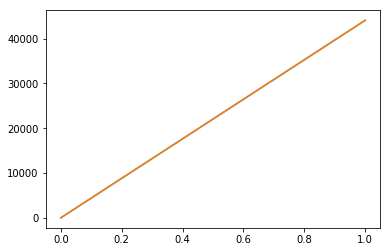

In [68]:
from scipy import signal
sr =44100
new_sr = 44000
x = np.linspace(0, 1, sr, endpoint=False)
xnew = np.linspace(0, 1, new_sr, endpoint=False)
a = np.arange(0, sr)
b = signal.resample(a, new_sr)
print (len(a))
print (len(b))
plt.plot(x,a, xnew, b)
# plt.plot(b)

In [16]:
b = a.flatten()
print (b)

[ 1 10  2 20  3 30  4 40]


In [52]:
b = a.reshape(a.shape[0]*  a.shape[1])

In [53]:
b *= 2

In [54]:
a

array([[ 2, 20],
       [ 4, 40],
       [ 6, 60],
       [ 8, 80]])

In [38]:
print (a)

[[ 10 100]
 [ 20 200]
 [ 30 300]
 [ 40 400]]


In [40]:
b = a.flatten()

In [ ]:

a_ver = np.mean(a, axis = 1)
print (a_ver)


In [ ]:
a = np.arange(1, 50000)
print (a)
print (np.repeat(a, 4, axis = 0).reshape(len(a), 4))
%timeit np.repeat(a, 4, axis = 0).reshape(len(a), 4)

In [ ]:
b = np.arange(1, 500000)
print (b)
print (np.dstack([b]*4))
%timeit np.dstack([b]*4)

In [ ]:
c =convertstack(b)
%timeit convertstack(b)
c

In [ ]:
def mono2chan(b):
    c = np.repeat(b, 4)
#     return c.reshape(len(b), 4)
    return c
     

In [ ]:
c = mono2chan(b)
%timeit mono2chan(b)
c

In [51]:
a = np.arange(0, 44100)

In [53]:
def makechunk2(lst, chunk):
    result = []
    lst = np.pad(lst, (0, lst.shape[0]%chunk), 'constant')
    for i in np.arange(0, len(lst), chunk):
        temp = lst[i:i + chunk]
        result.append(temp)
    return result
c = makechunk(a, 512)
# %timeit c = makechunk(a, 512)

In [54]:
np.array_equal(c,b)

True

In [43]:
a = [1,2,3]
print (np.min(a))

1
